In [ ]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.engine import engine, connectivity
from quetzal.io import excel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the transport network.
## Saves access and egress links for each zone.
## Needs all networks.


In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [ ]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [4]:
road = stepmodel.read_json('../input_static/de_road_network')

## Build access and egress links from zone centroids

In [6]:
# Compute controids
sm.preparation_ntlegs(
    zone_to_transit=False,
    zone_to_road=False)

In [7]:
# Compute road access and egress links
sm.zone_to_road = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids,
    road.road_nodes,
    short_leg_speed=params['pt_access']['speed_walk'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=params['access-egress_links']['n_road'],
    coordinates_unit=sm.coordinates_unit)
sm.zone_to_road = sm.zone_to_road.loc[
    sm.zone_to_road['distance']<=params['access-egress_links']['road_max_dist']]
len(sm.zone_to_road.index)

1604

In [8]:
# Compute road - PT links
sm.road_to_transit = engine.ntlegs_from_centroids_and_nodes(
    sm.nodes,
    road.road_nodes,
    short_leg_speed=params['pt_access']['speed_walk'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=params['access-egress_links']['n_road_pt'],
    coordinates_unit=sm.coordinates_unit)
sm.zone_to_road = sm.zone_to_road.loc[
    sm.zone_to_road['distance']<=params['access-egress_links']['road_pt_max_dist']]
len(sm.road_to_transit.index)

3038

In [9]:
# Build PT connectors by route type
# Every route type is saved once in this attribute
assert len(sm.pt_route_types) == len(sm.links['route_type'].unique())
sm.pt_route_types

['rail_long',
 'coach',
 'air',
 'bus',
 'subway',
 'ferry',
 'funicular',
 'rail_short']

In [10]:
# Replace subway and tram with bus to prevent errors
sm.pt_route_types = [t for t in sm.pt_route_types if t in sm.nodes['route_type'].unique()]
sm.pt_route_types

['rail_long', 'coach', 'air', 'bus', 'rail_short']

In [11]:
sm.zone_to_transit = sm.zone_to_transit.iloc[0:0]
for t in sm.pt_route_types:
    ntlegs = engine.ntlegs_from_centroids_and_nodes(
        sm.centroids,
        sm.nodes.loc[sm.nodes['route_type']==t],
        short_leg_speed=params['pt_access']['speed_walk'],
        long_leg_speed=params['pt_access']['speed_car'],
        threshold=params['pt_access']['catchment_radius_walk'],
        n_neighbors=params['access-egress_links']['n_pt'],
        coordinates_unit=sm.coordinates_unit)
    # Cut off long links
    ntlegs = ntlegs.loc[ntlegs['distance']<=
                        params['access-egress_links']['pt_max_dist']]
    ntlegs['route_type'] = t
    sm.zone_to_transit = sm.zone_to_transit.append(ntlegs)
sm.zone_to_transit.reset_index(drop=True, inplace=True)
len(sm.zone_to_transit)

10088

In [12]:
# Remove connectors to other zones, if this zone
# has connection to the route type itself
ac = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access'].copy()
eg = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress'].copy()
ac['node_FID'] = ac['b'].map(sm.nodes['FID'].to_dict())
eg['node_FID'] = eg['a'].map(sm.nodes['FID'].to_dict())

def filter_connectors(group, zone_col):
    if len(group['node_FID'].unique()) > 1: # Connection to more than one zone
        return group.loc[group['node_FID']==group[zone_col]]
    else: # Only has this one (or zero) zone connection
        return group
ac = ac.groupby(['route_type', 'a']).apply(filter_connectors, zone_col='a').reset_index(drop=True)
eg = eg.groupby(['route_type', 'b']).apply(filter_connectors, zone_col='b').reset_index(drop=True)

sm.zone_to_transit = pd.concat([ac, eg]).reset_index(drop=True).drop('node_FID', axis=1)

In [13]:
len(sm.zone_to_transit)

5824

## Generate footpaths table

In [14]:
sm.nodes.shape

(3077, 4)

In [16]:
# Generate footpaths between modes manually
'''sm.footpaths = sm.footpaths.iloc[0:0]
for o in ['rail_short_distance', 'bus']:
    for d in [t for t in sm.pt_route_types if t!='bus']:
        if o != d:
            ntlegs = engine.ntlegs_from_centroids_and_nodes(
                sm.nodes.loc[sm.nodes['route_type']==o],
                sm.nodes.loc[sm.nodes['route_type']==d],
                short_leg_speed=params['pt_access']['speed_walk'],
                long_leg_speed=params['pt_access']['speed_bicycle'],
                threshold=params['pt_access']['catchment_radius_walk'],
                n_neighbors=params['access-egress_links']['n_long-pt_short-pt'],
                coordinates_unit=sm.coordinates_unit)
            if d == 'air':
                ntlegs = ntlegs.loc[ntlegs['distance']<=
                                    params['access-egress_links']['walk_air_max_dist']]
            else:
                ntlegs = ntlegs.loc[ntlegs['distance']<=
                                    params['access-egress_links']['walk_max_dist']]
            sm.footpaths = sm.footpaths.append(ntlegs)'''
# Uses the Voronoi algorithm (slow for more nodes than 1000)
# but good results
sm.preparation_footpaths(
    speed=params['pt_access']['speed_walk'],
    max_length=params['access-egress_links']['walk_max_dist'],
    n_clusters=3000)

Manual version


In [17]:
len(sm.footpaths)

9706

In [18]:
# Number of nodes that overlay each other
sm.footpaths.loc[sm.footpaths['length']==0].shape

(5490, 6)

In [19]:
# Generate footpaths between centroids
ntlegs = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids,
    sm.centroids,
    short_leg_speed=params['pt_access']['speed_bicycle'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=threshold,
    n_neighbors=2,
    coordinates_unit=sm.coordinates_unit)
ntlegs = ntlegs.loc[ntlegs['distance']<=
                    params['access-egress_links']['bicycle_max_dist']]
ntlegs = ntlegs.loc[ntlegs['distance']!=0]
ntlegs.drop_duplicates(['direction', 'distance', 'time'], inplace=True)
ntlegs.shape

(438, 11)

In [20]:
sm.footpaths = sm.footpaths.append(ntlegs.rename(
    columns={'distance':'length', 'rank':'voronoi'})[sm.footpaths.columns])

In [21]:
# Reindex
sm.footpaths.reset_index(drop=True, inplace=True)
sm.footpaths.index = 'foot_' + pd.Series(sm.footpaths.index).astype(str)

In [22]:
sm.footpaths.sample(2)

,a,b,geometry,length,voronoi,time
foot_863,DEA51_r_s_3,DEA51_r_s_0,LINESTRING (7.214549333333333 51.4773956666666...,3131.657251,1,2818.491526
foot_9170,r_l_n_1409,r_l_n_283,"LINESTRING (7.834734 48.340435, 7.834734 48.34...",0.000000,0,0.000000


## Parametrise access and egress links

In [23]:
# Road - PT connectors
sm.road_to_transit['distance'] = 0
sm.road_to_transit['time'] = params['access-egress_links']['time_road_pt']
sm.road_to_transit.sample(n=2)

,a,b,direction,distance,geometry,rank,speed_factor,short_leg_speed,long_leg_speed,speed,time
4012,1570930026,coach_n_FLIXBUS:3878,eggress,0,"LINESTRING (11.37381 50.65025, 11.3726999 50.6...",0,0.404993,4,17,4.0,300
1674,DE113_bus_4,1594370388,access,0,LINESTRING (9.19971285627879 48.66629005660401...,0,0.300046,4,17,4.0,300


In [24]:
# Road - centroid connectors
sm.zone_to_road['distance'] = 0
sm.zone_to_road['time'] = params['access-egress_links']['time_road']
sm.zone_to_road.sample(n=2)

,a,b,direction,distance,geometry,rank,speed_factor,short_leg_speed,long_leg_speed,speed,time
380,DEG0I,1772536291,access,0,LINESTRING (11.30910260539643 50.6377834664522...,0,2.350851,4,17,9.403403,0
196,DE918,253749595,access,0,LINESTRING (9.847955045776768 51.7426266240809...,0,3.074574,4,17,12.298294,0


In [25]:
# Zone to PT:
# Load distances to PT stops from census data
clusters = pd.read_csv(input_path + 'spatial_census_refined.csv')
clusters.set_index('Unnamed: 0', inplace=True)
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
#pop_col = 'population'
node_col = 'node_id'

In [26]:
# Create a zone - distance - type dict
# Take the mean weighted distance, assume population shares are about equal
zone_type_dist = clusters.groupby(['NUTS_ID', 'route_type']).agg(
    {mean_dist_col: 'mean'})#.to_dict()[mean_dist_col]
zone_type_dist

mean_weighted_dist
NUTS_ID route_type                             
DE111   bus                         2694.602782
        coach                       4942.656226
        rail_long_distance          8481.451821
        rail_short_distance         7411.629367
DE112   bus                         5536.340993
...                                         ...
DEG0N   coach                       1705.112486
        rail_long_distance          5430.362740
        rail_short_distance         5155.025292
DEG0P   bus                         6024.588180
        rail_short_distance        26295.290877

[1232 rows x 1 columns]

In [27]:
# Split legs into access and egress
access = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access'].copy()
egress = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress'].copy()# name in quetzal

In [28]:
# Alter the distance
route_types = clusters['route_type'].unique()
for t in route_types:
    for zone in list(sm.zones['NUTS_ID']):
        try:
            access.loc[(access['route_type']==t) & (access['a']==zone),
                       'distance'] = zone_type_dist.loc[(zone, t), mean_dist_col]
        except KeyError:
            # There is no such station in this zone
            access.loc[(access['route_type']==t) & (access['a']==zone),
                       'distance'] = np.nan
for t in route_types:
    for zone in list(sm.zones['NUTS_ID']):
        try:
            egress.loc[(egress['route_type']==t) & (egress['b']==zone),
                       'distance'] = zone_type_dist.loc[(zone, t), mean_dist_col]
        except KeyError:
            # There is no such station in this zone
            egress.loc[(egress['route_type']==t) & (egress['b']==zone),
                       'distance'] = np.nan

In [29]:
sm.zone_to_transit = access.append(egress)

In [30]:
# Connections to nodes in other zones
len(sm.zone_to_transit.loc[sm.zone_to_transit['distance'].isna()])

244

<AxesSubplot:>

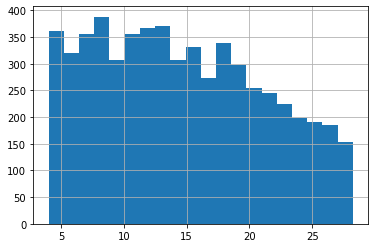

In [31]:
sm.zone_to_transit['speed'].hist(bins=20)

In [32]:
# Alter time of PT legs
sm.zone_to_transit['time'] = sm.zone_to_transit['distance'] / \
    sm.zone_to_transit['speed'] * 3.6 # in s
sm.zone_to_transit['time'].fillna(5*60, inplace=True)

In [33]:
# Replace NaN
#sm.zone_to_transit.loc[sm.zone_to_transit['distance'].isna(), 'distance'] = 0
#sm.zone_to_transit.loc[sm.zone_to_transit['speed'].isna(), 'speed'] = 0
# Drop them because they cause that people don't take short-distance PT,
# but walk over to the next airport and walk to the neighboring centroid
sm.zone_to_transit = sm.zone_to_transit.loc[sm.zone_to_transit['distance'].notna()]

In [34]:
print(len(sm.zone_to_transit))
sm.zone_to_transit.sample()

5580


,a,b,direction,distance,geometry,long_leg_speed,rank,route_type,short_leg_speed,speed,speed_factor,time
5243,DE251_r_s_2,DE251,eggress,1212.067964,"LINESTRING (10.56391 49.29210, 10.57795 49.29801)",50.0,1.0,rail_short,4.0,6.227855,1.556964,700.63366


<AxesSubplot:>

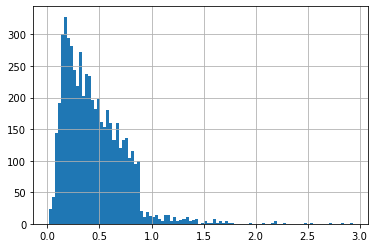

In [35]:
(sm.zone_to_transit['time']/3600).hist(bins=100)

In [36]:
# Ditch all legs which take too long
sm.zone_to_transit = sm.zone_to_transit.loc[sm.zone_to_transit['time']<5400]
len(sm.zone_to_transit)

5526

## Save model

In [37]:
# Drop unneccessary columns
cols = ['speed_factor', 'short_leg_speed', 'long_leg_speed', 'rank', 'voronoi', 'walk_time']
sm.footpaths.drop(cols, axis=1, inplace=True, errors='ignore')
sm.zone_to_transit.drop(cols, axis=1, inplace=True, errors='ignore')

In [38]:
sm.zone_to_road.drop(cols, axis=1, inplace=True, errors='ignore')
sm.road_to_transit.drop(cols, axis=1, inplace=True, errors='ignore')

In [39]:
# Make tables lighter
cols = ['distance', 'speed', 'time']
sm.zone_to_transit[cols] = sm.zone_to_transit[cols].astype(int)
sm.zone_to_road[cols] = sm.zone_to_road[cols].astype(int)
sm.road_to_transit[cols] = sm.road_to_transit[cols].astype(int)
try:
    sm.footpaths[cols] = sm.footpaths[cols].astype(int)
except KeyError:
    cols = ['length', 'time']
    sm.footpaths[cols] = sm.footpaths[cols].astype(int)

In [40]:
sm.footpaths.sample()

,a,b,geometry,length,time
foot_865,r_l_n_1025,coach_n_FLIXBUS:50,"LINESTRING (7.223275 51.478607, 7.22485 51.47931)",134,120


In [41]:
# Saving model...
tables = ['centroids', 'footpaths', 'zone_to_transit']
sm.to_json(model_path + 'de_pt_access_egress',
           only_attributes=tables, encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.95it/s]


In [42]:
sm.to_json(model_path + 'de_road_access_egress',
           only_attributes=['centroids', 'zone_to_road', 'road_to_transit'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 35.08it/s]
